In [1]:
import jax
import jax.numpy as jnp
from jax import random, jit, vmap, value_and_grad, jacrev
from jax.flatten_util import ravel_pytree
import optax
import matplotlib.pyplot as plt
import numpy as np

import neural_tangents as nt
from neural_tangents import stax

from typing import Callable, Optional, Tuple, List, Union

# Configure Matplotlib for better inline plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8-whitegrid')

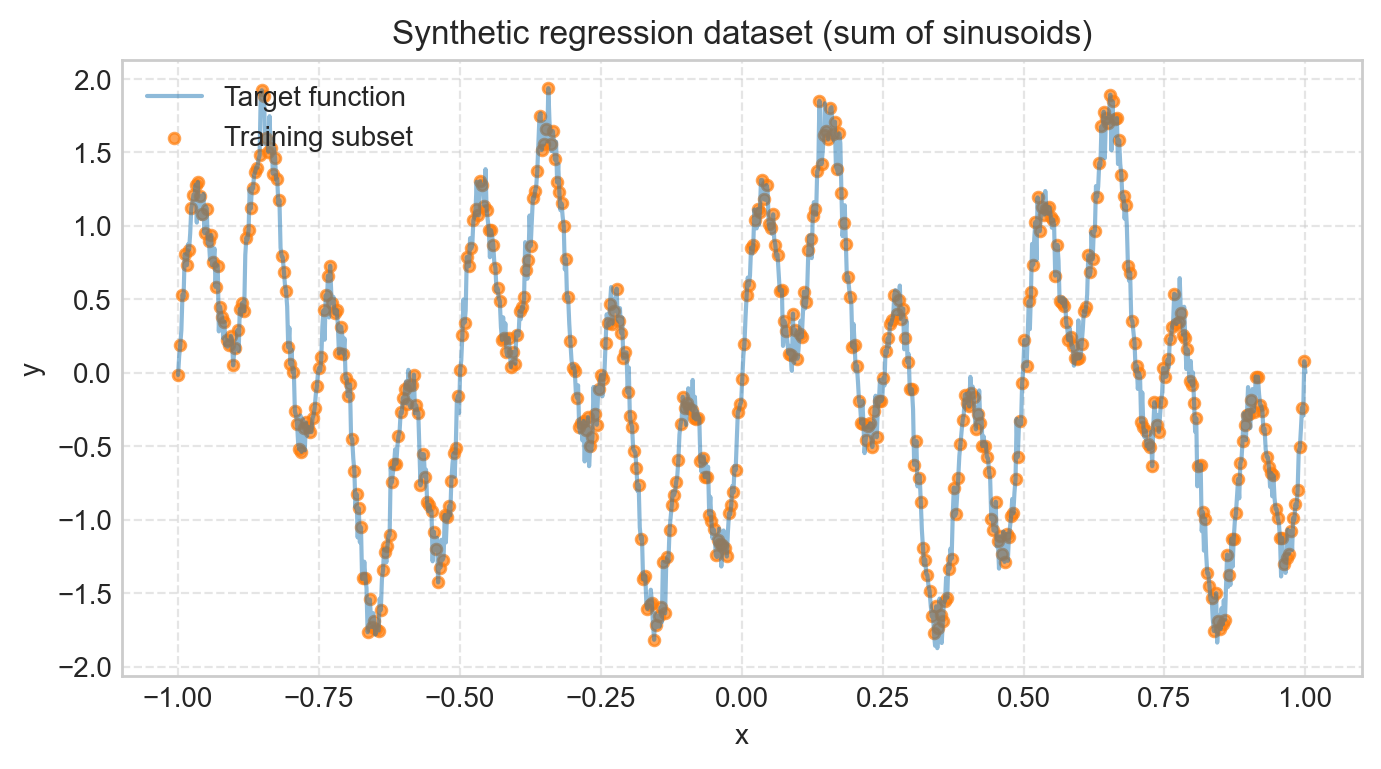

In [2]:
# ----- Data -----
x = jnp.linspace(-1.0, 1.0, 1024)[:, None]          # shape [n, 1]
y = (jnp.sin(4*jnp.pi*x) + 0.8*jnp.sin(16*jnp.pi*x)).squeeze()  # shape [n]

noise = 0.10 * jax.random.normal(jax.random.PRNGKey(1), y.shape)
y = y + noise

# ----- Randomly drop a fraction of points BEFORE splitting -----
keep_frac = 0.6                       # keep 60% (drop 40%);
N = x.shape[0]
n_keep = int(keep_frac * N)

# pick a training subset to speed up NTK computations:
idx = jnp.arange(0, x.shape[0], 2)
X_train, y_train = x[0::2], y[0::2]
X_test,  y_test  = x[1::2], y[1::2]

# visualize full dataset
plt.figure(figsize=(8, 4))
plt.plot(x, y, label='Target function', color='C0', alpha=0.5)
plt.scatter(X_train, y_train, color='C1', s=15, alpha=0.7, label='Training subset')
plt.title("Synthetic regression dataset (sum of sinusoids)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, ls='--', alpha=0.5)
plt.show()

In [3]:
X_train.shape, y_train.shape

((512, 1), (512,))

In [7]:
# ----- Define the network -----
width = 4096
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(width, b_std=0.05, parameterization='ntk'),
    stax.Relu(),
    stax.Dense(1,    b_std=0.05, parameterization='ntk')
)
apply_fn = jit(apply_fn)

# ----- Init -----
key = random.PRNGKey(0)
_, params = init_fn(key, X_train.shape)

# ----- Loss & optimizer (full-batch SGD ~ NTK gradient flow) -----
def loss_fn(params, x, y_n):
    preds = apply_fn(params, x).squeeze()
    return jnp.mean((preds - y_n) ** 2)

opt = optax.sgd(learning_rate=1e-2)
opt_state = opt.init(params)                    

@jit
def step(params, opt_state, x, y_n):
    loss, grads = value_and_grad(loss_fn)(params, x, y_n)
    updates, opt_state = opt.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# Warm-up JIT
_ = step(params, opt_state, X_train[:8], y_train[:8])

# ----- Train -----
n_steps = 50000
log_every = 1000
for i in range(1, n_steps + 1):
    params, opt_state, loss = step(params, opt_state, X_train, y_train)
    if i % log_every == 0 or i == 1 or i == n_steps:
        tr = float(loss_fn(params, X_train, y_train))
        te = float(loss_fn(params, X_test,  y_test))
        print(f"Step {i:5d} | Train MSE(n)={tr:.4e} | Test MSE(n)={te:.4e}")

Step     1 | Train MSE(n)=8.7090e-01 | Test MSE(n)=8.6750e-01
Step  1000 | Train MSE(n)=7.9890e-01 | Test MSE(n)=7.9375e-01
Step  2000 | Train MSE(n)=7.9753e-01 | Test MSE(n)=7.9231e-01
Step  3000 | Train MSE(n)=7.9647e-01 | Test MSE(n)=7.9126e-01
Step  4000 | Train MSE(n)=7.9549e-01 | Test MSE(n)=7.9031e-01
Step  5000 | Train MSE(n)=7.9453e-01 | Test MSE(n)=7.8936e-01
Step  6000 | Train MSE(n)=7.9361e-01 | Test MSE(n)=7.8846e-01
Step  7000 | Train MSE(n)=7.9273e-01 | Test MSE(n)=7.8760e-01
Step  8000 | Train MSE(n)=7.9188e-01 | Test MSE(n)=7.8676e-01
Step  9000 | Train MSE(n)=7.9102e-01 | Test MSE(n)=7.8592e-01
Step 10000 | Train MSE(n)=7.9023e-01 | Test MSE(n)=7.8514e-01
Step 11000 | Train MSE(n)=7.8945e-01 | Test MSE(n)=7.8437e-01
Step 12000 | Train MSE(n)=7.8868e-01 | Test MSE(n)=7.8362e-01
Step 13000 | Train MSE(n)=7.8793e-01 | Test MSE(n)=7.8289e-01
Step 14000 | Train MSE(n)=7.8721e-01 | Test MSE(n)=7.8218e-01
Step 15000 | Train MSE(n)=7.8650e-01 | Test MSE(n)=7.8149e-01
Step 160

In [8]:
# ----- Infinite-width NTK predictor (kernel ridge on normalized y) -----
reg = 1e-6
K_tt = kernel_fn(X_train, X_train, get='ntk')                   
K_xt = kernel_fn(X_test,  X_train, get='ntk')
alpha = jnp.linalg.solve(K_tt + reg * jnp.eye(K_tt.shape[0]), y_train[:, None])  # [N,1]

y_pred_inf = (K_xt @ alpha).squeeze()

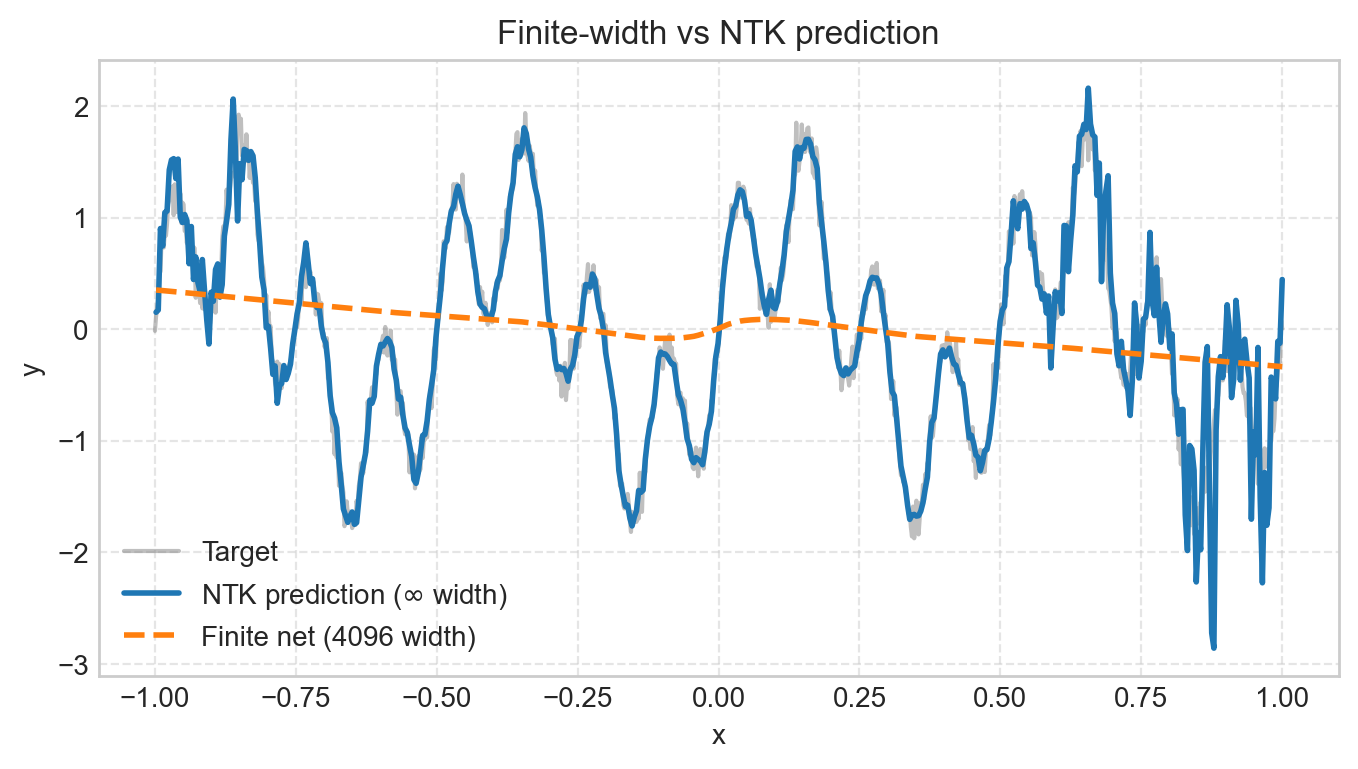

In [9]:
# ----- Finite net predictions (denormalize to compare) -----
y_pred_finite = apply_fn(params, X_test).squeeze()

# ----- Plot -----
plt.figure(figsize=(8, 4))
plt.plot(x, y, label='Target', color='gray', alpha=0.5)
plt.plot(X_test, y_pred_inf,     label=r"NTK prediction ($\infty$ width)", lw=2)
plt.plot(X_test, y_pred_finite, '--', label=f"Finite net ({width} width)", lw=2)
plt.legend()
plt.title("Finite-width vs NTK prediction")
plt.xlabel("x"); plt.ylabel("y")
plt.grid(True, ls='--', alpha=0.5)
plt.show()

In [13]:
# # Compute kernel matrices
# ntk_train_train = kernel_fn(X_train, X_train, 'ntk')
# ntk_test_train  = kernel_fn(X_test, X_train, 'ntk')

# # Regularization for numerical stability
# reg = 1e-6

# # Define predictor function (infinite-width NTK dynamics)
# predict_fn = nt.predict.gradient_descent_mse(
#     ntk_train_train, y_train, diag_reg=reg
# )

In [14]:
# Predict on test points
y_pred_inf = predict_fn(None, ntk_test_train)

y_pred_inf.shape

(512,)

In [22]:
# Evaluate trained network
y_pred_finite = apply_fn(params, X_test).squeeze()


# sort X_test for pretty line plots
order_te       = np.asarray(jnp.argsort(X_test[:, 0]))
X_test_sorted  = np.asarray(X_test[order_te])
y_inf_sorted   = y_pred_inf[order_te]
y_fin_sorted   = y_pred_finite[order_te]

plt.figure(figsize=(8, 4))
plt.plot(X_full_sorted, y_full_sorted, label='Target', color='gray', alpha=0.5)
plt.plot(X_test_sorted, y_inf_sorted,    label=r"NTK prediction ($\infty$ width)", lw=2)
plt.plot(X_test_sorted, y_fin_sorted, '--', label=f"Finite net ({width} width)", lw=2)
plt.scatter(np.asarray(X_train), np.asarray(y_train), s=15, alpha=0.6, label='Train')
plt.legend()
plt.title("Finite-width vs NTK prediction")
plt.xlabel("x"); plt.ylabel("y")
plt.grid(True, ls='--', alpha=0.5)
plt.show()

NameError: name 'np' is not defined